# Case 1
Dan Suman<br>
Last edited: 27.01.2019<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives

The main objectives for this case study are: 
 - understand the basics of file processing using panda library 
 - create a simple and fast neural network model for the heart disease classification problem using keras
     1. using categorical classification
     2. using binary classification

## 2. Required libraries


In [373]:
# Import libraries
%pylab inline
import time
import warnings
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import models, layers, initializers, regularizers
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/Users/dsuman/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'shuffle', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 3. Data description and preprocessing

I will be using the provided preprocessed cleveland data for this classification problem. I will substitute the missing values from the rows with the column medians in order to interfere as less as possible with the data integrity. Data will be normalized in order to speed up the computations and provide more accurate (in most cases) predictions. Training and validation data will be split with the following proportion: 2/1 (approximately). Training sets will be split for both analyzed cases (categorical and binary). Based on correlation heatmap will select only columns having postive correlations. 

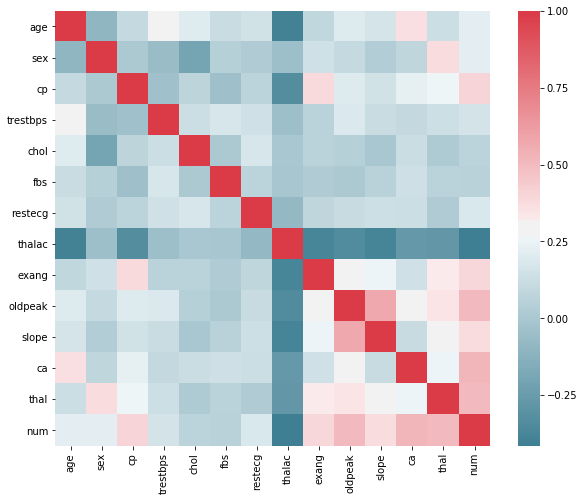

In [120]:
# Import data
url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
dataframe = pd.read_csv(url, 
                        sep = ',', 
                        header = None, 
                        index_col = None,
                        na_values = '?')

# Add column names
name_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']
dataframe.columns = name_list

# Fill missing data with columnwise median values
dataframe = dataframe.fillna(dataframe.median())


# Generate correlation heatmap
f, ax = plt.subplots(figsize=(10, 8))
corr = dataframe.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


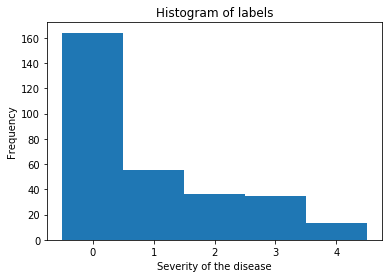

Shape of data and one-hot-labels: (303, 9) (303, 5)


In [121]:
# Randomize rows
dataframe = shuffle(dataframe)
dataframe.tail()

# Check the descriptive statistics
dataframe.describe()

# Select the data (input) columns
data_list = ['age', 'sex', 'cp','restecg','exang','oldpeak','slope','ca','thal']
data = dataframe[data_list]

# Scale the data
data_min = data.min()
data_max = data.max()
data_norm = (data - data_min)/(data_max - data_min)

# Check descriptive statistics of normalized data
data_norm.describe()

# Select labels (output)
labels = dataframe['num']

# Plot the histogram of the labels (severity of the disease)
plt.hist(labels, bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel('Severity of the disease')
plt.ylabel('Frequency')
plt.title('Histogram of labels')
show()

# Code labels to categorical output
one_hot_labels = to_categorical(labels)
one_hot_labels[:5]

# Make binary labels
bin_labels = 1.0*(labels > 0.0)

# Check the shapes of the normalized data and categorical output
print('Shape of data and one-hot-labels:', data_norm.shape, one_hot_labels.shape)

# Split the data and labels into training and validation sets
train_data = data_norm[:200]
val_data = data_norm[200:]
train_data_binary = data_norm[:200]
val_data_binary = data_norm[200:]

train_labels = one_hot_labels[:200]
train_labels_binary = bin_labels[:200]
val_labels = one_hot_labels[200:]
val_labels_binary = bin_labels[200:]

## 4. Modeling and compilation


I will be using, as per assingment, a sequential network of dense layers. Throughout the case study, as to improve the accuracy of the model, and to avoid model overfitting, a series of improvements will be tried out: 
- Different activation functions (function resposnible for neuron activation on each layer): https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/
- Overfitting regularization techniques: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/
    1. L1 and L2 parameter tuning. Those are additional input parameters for our cost function.
    2. Dropout. At every iteration nodes are selected and dropped in order to generate more randomness.
    3. Early stopping. Model training could be stopped once our performance on validation set is getting worse/
- Different optimizers (even though ADAM is the optimizer performing better with sparse gradients) https://blog.algorithmia.com/introduction-to-optimizers/
- Normalization layer https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
- Different weight initializers https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/
    

In [265]:
# Build the model (categorical classification)
model = models.Sequential()
model.add(layers.Dense(9, activation='relu', input_shape=(9,),
                       kernel_regularizer=regularizers.l1_l2(l1=0.003, l2=0.01),
                       kernel_initializer=initializers.glorot_uniform(seed=1)))
# model.add(layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.Dense(9, activation='relu', 
                       kernel_regularizer=regularizers.l1_l2(l1=0.003, l2=0.01),
                       kernel_initializer=initializers.glorot_uniform(seed=1)))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 9)                 90        
_________________________________________________________________
dropout_85 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_166 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_167 (Dense)            (None, 5)                 50        
Total params: 230
Trainable params: 230
Non-trainable params: 0
_________________________________________________________________


In [378]:
# Build the model (binary classification)
model_binary = models.Sequential()
model_binary.add(layers.Dense(9, activation='relu', input_shape=(9,)))
model_binary.add(layers.Dense(9, activation='relu'))
model_binary.add(layers.Dense(1, activation='sigmoid'))
model_binary.summary()

# Compile the model
model_binary.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_248 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_249 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_250 (Dense)            (None, 1)                 10        
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________


## 5. Training and Validation

In [267]:
# Fit the model with the data and keep record on elapsed time
t_start = time.time()
history = model.fit(train_data, train_labels, 
                    epochs = 600, 
                    batch_size = 16, 
                    verbose = 0,
                    validation_data = (val_data, val_labels))
t_end = time.time()
print('Elapsed time: {:.2f} seconds'.format(t_end - t_start))

Elapsed time: 47.98 seconds


In [379]:
early_stopper = EarlyStopping(patience=3)

# Fit the model with the data and keep record on elapsed time
t_start_binary = time.time()
history_binary = model_binary.fit(train_data_binary, train_labels_binary, 
                    epochs = 800, 
                    batch_size = 16, 
                    verbose = 0,
                    validation_data = (val_data_binary, val_labels_binary),
                    callbacks=[early_stopper])
t_end_binary = time.time()
print('Elapsed time: {:.2f} seconds'.format(t_end_binary - t_start_binary))

Elapsed time: 13.35 seconds


## 6. Evaluation

In [269]:
# Get the training data
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)


# Print total accuracy and confusion matrix
val_predicts = model.predict(data_norm)
y_pred = argmax(val_predicts, axis = 1)
cm = confusion_matrix(labels, y_pred)

# Best guess = Guess that all are normal
# ==> Normal cases are correctly classified
# Normal cases can be counted by summing all labels that are zeros
print('Best guess: {:.4f}'.format(np.sum(labels == 0)/len(labels)))

# Accuracy can be calculated from the confusion matrix by
# counting all elements in diagonal (=trace of the matrix)
print('Total accuracy: {:.4f}'.format(np.trace(cm)/sum(cm)))
print('Confusion matrix:')
print(cm)



# Calculate precision, recall, fscore and support
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p, r, f, s = precision_recall_fscore_support(labels, y_pred)

# Print precision, recall, fscore and support  
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print('Support:\n', s)
print('Precision:', p)
print('Recall:   ', r)
print('F-score:  ', f)


Best guess: 0.5413
Total accuracy: 0.6469
Confusion matrix:
[[159   2   0   3   0]
 [ 29   7   5  14   0]
 [  7   4   3  22   0]
 [  3   4   1  27   0]
 [  1   0   0  12   0]]
Support:
 [164  55  36  35  13]
Precision: [ 0.799  0.412  0.333  0.346  0.000]
Recall:    [ 0.970  0.127  0.083  0.771  0.000]
F-score:   [ 0.876  0.194  0.133  0.478  0.000]


In [380]:
# Get the training data
history_dict_binary = history_binary.history
loss_values_binary = history_dict_binary['loss']
val_loss_values_binary = history_dict_binary['val_loss']
acc_values_binary = history_dict_binary['acc']
val_acc_values_binary = history_dict_binary['val_acc']
epochs_binary = range(1, len(loss_values_binary) + 1)

score = model_binary.evaluate(val_data_binary, val_labels_binary, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

103/103 [==============================] - 0s 226us/step
Test score: 0.38215600547281287
Test accuracy: 0.8252427190252878


## 7. Results and Discussion

In the graphs down below the training process can be visualized. In the first graph it can be noticed that the validation loss is diverging from the training loss with the growth of epoch numbers. This is a sign of overfitting, a common issue for this dataset. The overfitting efforts taken while trying to preserve accuracy (second graph) include dropout optimization, l1 and l2 parameter tweaking as well as weight initializer per layer. (For more details follow the links in paragraph 4).

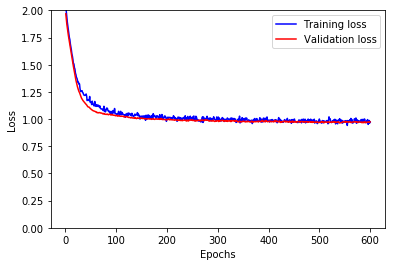

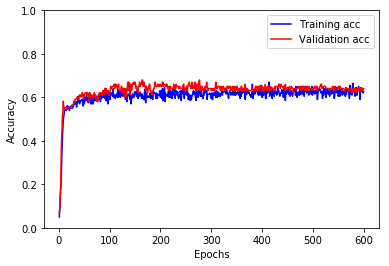

In [272]:
import matplotlib.pyplot as plt
# Visualize the training process: loss function
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()

# Visualize the accuracy
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

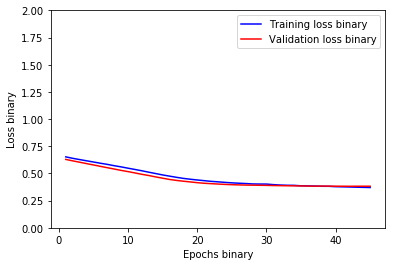

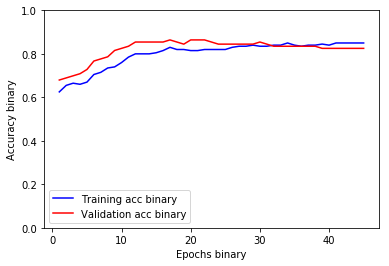

In [381]:
import matplotlib.pyplot as plt
# Visualize the training process: loss function
plt.figure()
plt.plot(epochs_binary, loss_values_binary, 'b', label='Training loss binary')
plt.plot(epochs_binary, val_loss_values_binary, 'r', label='Validation loss binary')
plt.xlabel('Epochs binary')
plt.ylabel('Loss binary')
plt.ylim([0, 2])
plt.legend()
plt.show()

# Visualize the accuracy
plt.figure()
plt.plot(epochs_binary, acc_values_binary, 'b', label='Training acc binary')
plt.plot(epochs_binary, val_acc_values_binary, 'r', label='Validation acc binary')
plt.xlabel('Epochs binary')
plt.ylabel('Accuracy binary')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 8. Conclusions

I have started the task by selecting the most releavant feature columns. Although in Deep Learning field feature selection is discouraged (the feature selection itself is done by the NN https://www.researchgate.net/post/Do_Deep_Learning_Networks_use_any_Feature_selection_method_such_as_NSGA_RFE_or_PCA) I have dropped a set of columns which seemed to have close to no correlation according to the heatmap. I have continued with a lot of fine tuning of parameters, required in order to get satisfactory results. I have identified in true randomization the biggest challenge. Considered that NN's are trained using non-deterministic search algorithms (stochastic gradient descent) finding the correct weights for the mapping function requires a set of optimizations. For the categorical classification case study I have used glorot_uniform initializer for the relu activation function for the first two layers, in combination with L1 and L2 parameters. For the binary classification case study I have used two hidden layers with 9 neurons each and relu activation function, in combination with an EarlyStopper callback. The secondary challenge was overfitting, partially addressed in the previously described tweaks. Conidered the small data set, dropout in between layers as added, and batch normalization was considered (leading to worse results). To further improve the accuracy, [k-fold](https://machinelearningmastery.com/k-fold-cross-validation/) will be considered as a potential addition, although a lot of challenges could be solved by extending the dataset size. 